In [4]:
import numpy as np
from scipy.optimize import root
from scipy.integrate import solve_ivp
from scipy.linalg import solve_continuous_are
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline
from scipy import linalg

### LQR Finite-Horizon Approach

In [16]:
def linearized_init(delta, gamma, m0, c, q1, q2, q3, q4, q5, q6, q7, r, m):
    """ Finite LQR Setup for freeway onramp
    Parameters:
    ----------
        delta, gamma: floats
            tunable paramaters for pre-merge freeway entering and leaving rates
        m0   : float
            initial number of cars in the merge area on a given interval 
        qi, r, m : floats
            q_k weights in Q matrix
            r weights in R matrix
            m weights in M matrix


    Return
    -------
        A : ndarray of shape (6,6)
            State evolution equation matrix for q(t)
        B : ndarray of shape (6,1)
            State evolution equation matrix for u(t)
        Q : ndarray of shape (6,6)
            Cost functional matrix for q(t)
        R : ndarray of shape (1,1)
            Cost functional matrix for u(t)
        M : ndarray of shape (6,6)
            Cost functional matrix for q(tf)
    """
    # [alpha, beta, m, l, n, q]
    A = np.array([
        [0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0],
        [0,0,1,-delta-2*delta*m0/c,0,delta,0],
        [0,0,-1,delta+2*delta*m0/c,0,0,0],
        [1,0,0,0,0,-delta,0],
        [0,1,0,0,0,0,0]
    ])

    B = np.array([0,0,0,1,0,0,-1]).reshape(-1,1)
    Q = np.diag(np.array([q1, q2, q3, q4, q5, q6,q7]))
    R = np.array([[r]])
    M = np.eye(7)*m


    return A, B, Q, R, M

In [6]:
def onramp_solver_finite_horizon(A, B, Q, R, M, tf):
    """ Onramp solver for Finite Horizon LQR
        Uses Idea from 19.2 to find P(t) and then solve Ricatti

    Parameters:
    -----------
        A : ndarray of shape (6,6)
            State evolution equation matrix for q(t)
        B : ndarray of shape (6,1)
            State evolution equation matrix for u(t)
        Q : ndarray of shape (6,6)
            Cost functional matrix for q(t)
        R : ndarray of shape (1,1)
            Cost functional matrix for u(t)
        M : ndarray of shape (6,6)
            Cost functional matrix for q(tf)
    """
    # Setup R inverse
    R_inv = np.linalg.inv(R)


    # Setup the evolution equation for the Riccati 
    # equation (the linear 2D version)
    def riccati(t,x):
        dxdt = np.zeros((72))
        x=x.reshape((12,6))
        X = x[:6]
        Y = x[6:]
        dxdt[:36] = ((A @ X) + (0.5*B @ R_inv @ B.T @ Y)).flatten()
        dxdt[36:] = ((2*Q @ X) - (A.T @ Y)).flatten()
        return dxdt

    # Solve the Riccati equation, and make sure to
    # save the output densely so we can interpolate later on
    xf = np.zeros((72))
    xf[:36] = np.eye(6).flatten() # X(tf)
    xf[36:] = (-2*M).flatten() # Y(tf)
    p_sol = solve_ivp(riccati, [tf,0], xf, dense_output=True)

    # Setup the evolution equation with optimal control selected
    def onramp_evolve(t,y,p_sol):
        sol_p = p_sol.sol(t).reshape((12,6))
        X = sol_p[:6]
        Y = sol_p[6:]
        X_inv = np.linalg.inv(X)
        P = -.5*Y@X_inv
        return (A-B@R_inv@B.T@P)@y

    # Solve the forward model for the onramp,
    # Then compute the optimal control from the optimal state,
    # and plot the results
    y0 = np.array([1,1,1,1,1,1])
    final_sol = solve_ivp(onramp_evolve, [0,tf], y0, args=[p_sol], dense_output=True)

    return final_sol, p_sol

In [7]:
# Setup initial values and conditions for onramp
# delta, gamma, m0, c = 0.5, 0.3, 1.0, 4.0
# q1, q2, q3, q4, q5, q6 = 1.0, 1.0, 1.0, 1.0, 1.0, 1.0
# r, m = 1.0, 1.0

delta, gamma, m0, c = 0.5, 0.3, 1.0, 2.0
q1, q2, q3, q4, q5, q6 = 0.0, 0.0, 1.0, 1.0, 1.0, 4.0
r, m = 1.0, 1.0
n_count = 1001
tf = 10
t_space = np.linspace(0,tf,n_count)

# Get LQR Matrices and Solve the Ricatti Equations for the state and costate
A, B, Q, R, M = linearized_init(delta, gamma, m0, c, q1, q2, q3, q4, q5, q6, r, m)
final_sol, p_sol = onramp_solver_finite_horizon(A, B, Q, R, M, tf)
R_inv = np.linalg.inv(R)

# Unpack the solution
solution = final_sol.sol(t_space)
alpha, beta, m, l, n, q = solution

# Calculate the optimal control
X = p_sol.sol(t_space)[:36,:]
Y = p_sol.sol(t_space)[36:,:]
u = np.zeros(n_count)
for t in range(n_count):
    X_t = X[:,t].reshape((6,6))
    Y_t = Y[:,t].reshape((6,6))
    X_t_inv = np.linalg.inv(X_t)
    P = -0.5*Y_t @ X_t_inv
    u[t] = (-R_inv @ B.T @ P @ solution[:,t].reshape(-1,1))[0][0]

plt.figure(figsize=(10,10))
# plt.plot(t_space, alpha, label="alpha")
# plt.plot(t_space, beta, label="beta")
plt.plot(t_space, m, label="m")
plt.plot(t_space, l, label="l")
plt.plot(t_space, n, label="n")
plt.plot(t_space, q, label="q")
plt.plot(t_space, u, label="u")
plt.legend()
plt.show()

TypeError: linearized_init() missing 1 required positional argument: 'm'

### LQR Infinite Horizon Approach

In [14]:
n_count = 1001
u = np.zeros(n_count)
def onramp_solver_infinite_horizon(A, B, Q, R, M, y0, t0, tf):
    """ Onramp solver for Infinite Horizon LQR
        Uses Continuous LQR

    Parameters:
    -----------
        A : ndarray of shape (6,6)
            State evolution equation matrix for q(t)
        B : ndarray of shape (6,1)
            State evolution equation matrix for u(t)
        Q : ndarray of shape (6,6)
            Cost functional matrix for q(t)
        R : ndarray of shape (1,1)
            Cost functional matrix for u(t)
        M : ndarray of shape (6,6)
            Cost functional matrix for q(tf)
    """
    R_inv = np.linalg.inv(R)

    # Solve for P with the algebraic Riccati equation
    P = linalg.solve_discrete_are(A,B,Q,R)

    # Setup the evolution equation with optimal control selected
    def onramp_evolve(t,y):
        return (A - B @ R_inv @ B.T @ P) @ y
    
    # Solve the optimal state evolution
    sol = solve_ivp(onramp_evolve, [t0,tf], y0, dense_output=True)
    return sol, P

In [8]:
# Setup initial values and conditions for onramp
delta, gamma, m0, c = 0.5, 0.3, 1.0, 4.0
q1, q2, q3, q4, q5, q6 = 0.0, 0.0, 1.0, 0.0, 1.0, 1.0
r, m = 1.0, 1.0
n_count = 101
t_space = np.linspace(0,10,n_count)

# Get LQR Matrices and Solve the Ricatti Equations for the state and costate
A, B, Q, R, M = linearized_init(delta, gamma, m0, c, q1, q2, q3, q4, q5, q6, r, m)
sol = onramp_solver_infinite_horizon(A, B, Q, R)

print(sol.sol(t_space).shape)

TypeError: onramp_solver_infinite_horizon() missing 4 required positional arguments: 'M', 'y0', 't0', and 'tf'

In [9]:
plt.plot(t_space, sol.sol(t_space)[2], label="m")
plt.plot(t_space, sol.sol(t_space)[3], label="l")
plt.plot(t_space, sol.sol(t_space)[4], label="n")
plt.plot(t_space, sol.sol(t_space)[5], label="q")
plt.legend()
plt.show()

NameError: name 'sol' is not defined

In [64]:
def multi_step_onramp_infinite_horizon(A, B, Q, R, M, y0, tf, num_intervals=10):
    R_inv = np.linalg.inv(R)
    n_count = 1001
    time_intervals = np.linspace(0, tf, num_intervals+1)

    alpha = np.zeros(n_count*num_intervals)
    beta = np.zeros(n_count*num_intervals)
    nu = np.zeros(n_count*num_intervals)
    m = np.zeros(n_count*num_intervals)
    l = np.zeros(n_count*num_intervals)
    n = np.zeros(n_count*num_intervals)
    q = np.zeros(n_count*num_intervals)
    u = np.zeros(n_count*num_intervals)

    for i in range(len(time_intervals)-1):
        t0, tf = time_intervals[i], time_intervals[i+1]
        t_space = np.linspace(t0, tf, n_count)
        final_sol, P = onramp_solver_infinite_horizon(A, B, Q, R, M, y0, t0, tf)
        i0, i1 = i*n_count, (i+1)*n_count

        solution = final_sol.sol(t_space)
        alpha[i0:i1], beta[i0:i1], nu[i0:i1], m[i0:i1], l[i0:i1], n[i0:i1], q[i0:i1] = solution

        for t in range(n_count):
            u[i0+t] = (-R_inv @ B.T @ P @ solution[:,t].reshape(-1,1))[0][0]

        y0 = solution[:,-1]
        m0 = y0[3]
        y0[2] = -delta*m0 - delta*m0**2/c + (-delta - 2*delta*m0/c)*m0

    return alpha, beta, nu, m, l, n, q, u,

<Figure size 3276.8x2457.6 with 0 Axes>

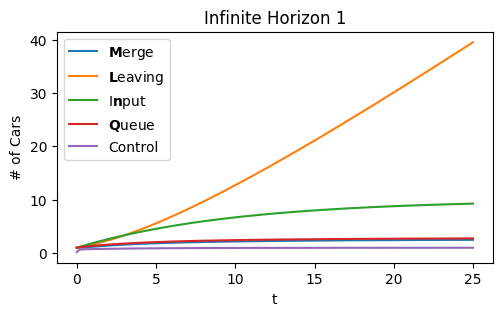

In [71]:
# delta, gamma, m0, c = 0.1, 0.3, 1.0, 2.0
delta, gamma, m0, c = 0.5, 0.3, 1.0, 2.0
q1, q2, q3, q4, q5, q6, q7 = 0.0, 0.0, 0.0, 4.0, 0.0, 3.0, 4.0
nu = -delta*m0 - delta*m0**2/c + (-delta - 2*delta*m0/c)*m0
r, m = 1.0, 1.0
n_count = 1001
tf = 10
num_intervals = 500
y0 = np.array([1,1,nu,1,1,1,1])
t_space = np.linspace(0,tf,num_intervals*n_count)

# Get LQR Matrices and Solve the Ricatti Equations for the state and costate
A, B, Q, R, M = linearized_init(delta, gamma, m0, c, q1, q2, q3, q4, q5, q6, q7, r, m)
alpha, beta, nu, m, l, n, q, u = multi_step_onramp_infinite_horizon(A, B, Q, R, M, y0, tf, num_intervals)

plt.gcf().set_dpi(512)
plt.figure(figsize=(3.75 * 1.5, 3))
# plt.plot(t_space, m, label=f"m")
# plt.plot(t_space, l, label=f"l")
# plt.plot(t_space, n, label=f"n")
# plt.plot(t_space, q, label=f"q")
# plt.plot(t_space, u, label=f"u")

plt.plot(t_space , m, label=f"$\\bf{{M}}$erge")
plt.plot(t_space , l, label=f"$\\bf{{L}}$eaving")
plt.plot(t_space , n, label=f"I$\\bf{{n}}$put")
plt.plot(t_space , q, label=f"$\\bf{{Q}}$ueue")
plt.plot(t_space , u, label=f"Control")


# plt.title(f"Initial Guess: {y0}\ndelta: {delta}, gamma: {gamma}, m0: {m0}, c: {c}, q6: {q6}")
plt.title("Infinite Horizon 1")
plt.xlabel("t")
plt.ylabel("# of Cars")
plt.legend()
plt.savefig(f"LQR_figures/infinite_multi.pdf", transparent=False)
# plt.show()